<a href="https://colab.research.google.com/github/sazidabintaislam/FineTunningVGG16/blob/main/VGG16_finetune_lizard3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#this code is inspired from this link: https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [3]:
# define and move to dataset directory
import os
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from datetime import datetime
import itertools 
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
trainPath = '/content/drive/MyDrive/lizard_background_CNN2/train'
valPath = '/content/drive/MyDrive/lizard_background_CNN2/valid'
testPath = '/content/drive/MyDrive/lizard_background_CNN2/test'

In [5]:
trainAug = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
testAug=ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
testAug.mean = mean

In [6]:
# initialize the training generator
batch_size = 32
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)
# initialize the testing generator
testGen = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)

Found 2890 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
#VGG16 = keras.applications.vgg16

from keras.layers import Input
from keras.applications import VGG16
from keras.models import Model
from keras.optimizers import Adam

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model

# Freeze four convolution blocks
for layer in baseModel.layers[:11]:
    layer.trainable = False
    
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
#headModel = Dense(512, activation="relu")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

model.summary() 

# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
    

58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable

totalTrain=2890
totalVal=700
print("compiling model...")
#opt = SGD(lr=1e-4, momentum=0.9)
opt = Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["acc"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("training head...")
H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // batch_size,
    validation_data=valGen,
    validation_steps=totalVal // batch_size,
    epochs=50)

compiling model...
training head...
Epoch 1/50
90/90 [==============================] - 1844s 20s/step - loss: 1.4855 - acc: 0.5477 - val_loss: 0.5951 - val_acc: 0.6949
Epoch 2/50
90/90 [==============================] - 184s 2s/step - loss: 0.6523 - acc: 0.6015 - val_loss: 0.6241 - val_acc: 0.6071
Epoch 3/50
90/90 [==============================] - 181s 2s/step - loss: 0.6444 - acc: 0.5729 - val_loss: 0.6282 - val_acc: 0.5729
Epoch 4/50
90/90 [==============================] - 182s 2s/step - loss: 0.6379 - acc: 0.5967 - val_loss: 0.6280 - val_acc: 0.5729
Epoch 5/50
90/90 [==============================] - 180s 2s/step - loss: 0.6287 - acc: 0.5963 - val_loss: 0.6298 - val_acc: 0.5729
Epoch 6/50
90/90 [==============================] - 178s 2s/step - loss: 0.6337 - acc: 0.5992 - val_loss: 1.6039 - val_acc: 0.5774
Epoch 7/50
90/90 [==============================] - 178s 2s/step - loss: 0.7402 - acc: 0.5275 - val_loss: 0.6952 - val_acc: 0.4792
Epoch 8/50
90/90 [===========================

In [9]:
target_names = []
for key in trainGen.class_indices:
    target_names.append(key)
    
print(target_names)


['background', 'lizard']


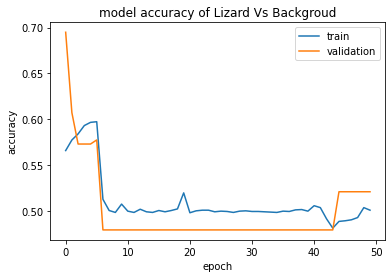

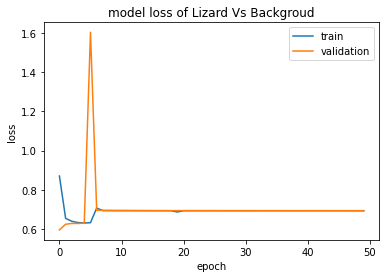

In [10]:
############################################
#Plot the Graph

acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy of Lizard Vs Backgroud')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc.png')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss of Lizard Vs Backgroud')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss.png')
plt.show()

In [11]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("evaluating after fine-tuning network head...")

totalTest=200
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // batch_size) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

evaluating after fine-tuning network head...
              precision    recall  f1-score   support

  background       0.50      1.00      0.67       100
      lizard       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization


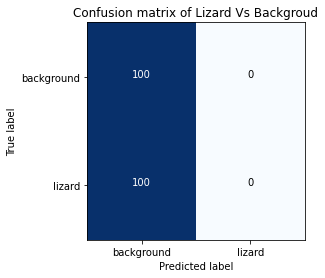

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix of snake Vs background', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

#thresh = cm.max() / 2.
#Matplotlib’s matshow
cm = confusion_matrix(testGen.classes, predIdxs)

plt.figure(3)
plot_confusion_matrix(cm, target_names, title='Confusion matrix of Lizard Vs Backgroud')
#print(cm)
plt.savefig('toad_VGG16.png')
plt.show()